# Energy Dataset

This script aims to apply different models to forecast future values in a time series. The models include various types of Exponential Smoothing (Simple, Holt, Additive Holt-Winters, Multiplicative Holt-Winters) and ARIMA models, with the best model selected using the 'auto_arima' function. The script also explores the impact of excluding outlier values from the time series.

The effectiveness of the models will be evaluated considering the complete dataset and also after removing the outlier values, using the MAPE (Mean Absolute Percentage Error), a common measure to assess the accuracy of forecasts in time series. The most accurate models will be plotted alongside the actual values, allowing for a visual analysis of the results.

## Dataset Description

The time series under analysis is the energy consumption in a region of Brazil, with data available from 1979 to the year 2020. Initially, the data prior to 2017 will be used to train the models, while the remaining data will be used to test the predictions. Subsequently, an additional analysis will be conducted by excluding the data corresponding to some months in 2020, during which the Brazilian GDP was heavily impacted by the COVID-19 pandemic. This will allow us to understand the performance of the models when these atypical data points are removed from the test set.


## Implementation


- Check the Dataset


- Create and Adjust the Exponential Smoothing Models


- Create and Adjust the best ARIMA Model


- Predict based on the adjusted models


- Repeat the processes excluding the outliers


- Analyze the results 

***

## Checking Dataset

In [1]:
# Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Dataset values
df_pib = pd.read_csv(f'Data/PIB.csv', index_col = 0)
df_pib.head(5)

,Data,pib
0,2004-01-01,144558.6
1,2004-02-01,142861.3
2,2004-03-01,157363.5
3,2004-04-01,156953.9
4,2004-05-01,159498.9


In [3]:
# Transforming the date column
df_pib['Data'] = pd.to_datetime(df_pib['Data'])

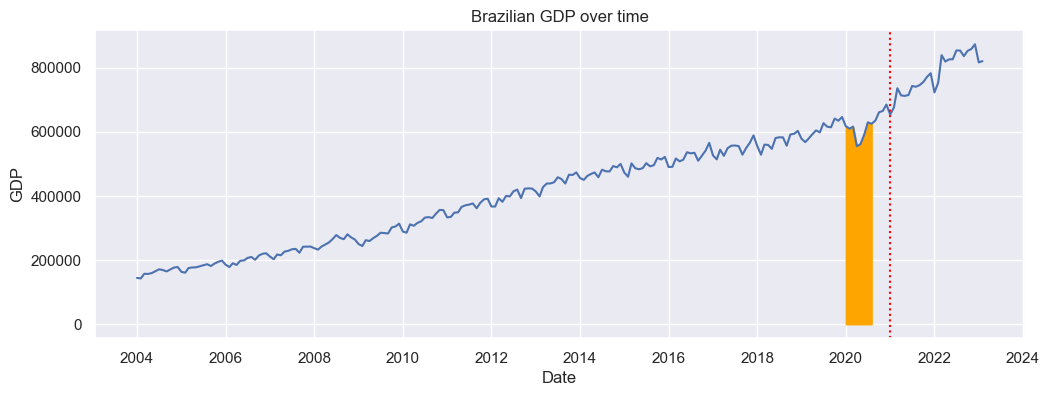

In [4]:
# Plotting the PIB over time
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 8, 1)
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'], df_pib['pib'])
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Brazilian GDP over time')
plt.fill_between(df_pib['Data'], df_pib['pib'], where=((df_pib['Data'] >= start_date) & (df_pib['Data'] <= end_date)), color='orange')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted');

The graph illustrates the trend of the Brazilian GDP over the years, beginning in 2004.

The dashed line marks the date from which the models will make predictions.

The shaded orange area corresponds to the initial months of the COVID pandemic, showing a noticeable deviation in the data pattern. This specific time window will be disregarded during a subsequent model adjustment.

In [5]:
# Decomposing the time series
decomposed_ts = sm.tsa.seasonal_decompose(df_pib['pib'], period=12)

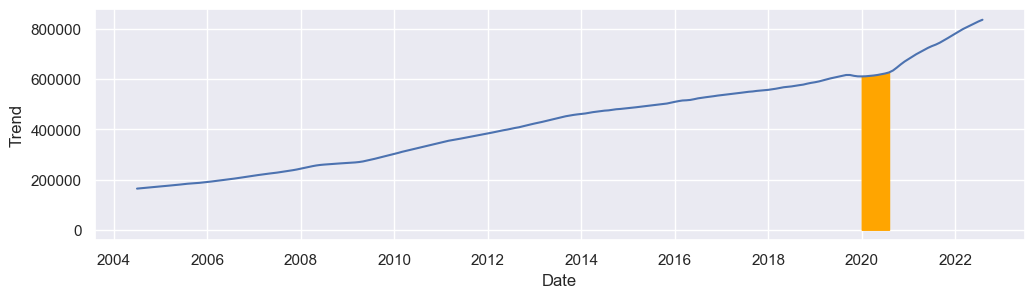

In [6]:
# Plotting the Trend
plt.figure(figsize=(12,3))
plt.plot(df_pib['Data'], decomposed_ts.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.fill_between(df_pib['Data'], decomposed_ts.trend, where=((df_pib['Data'] >= start_date) & (df_pib['Data'] <= end_date)), color='orange')
plt.show();

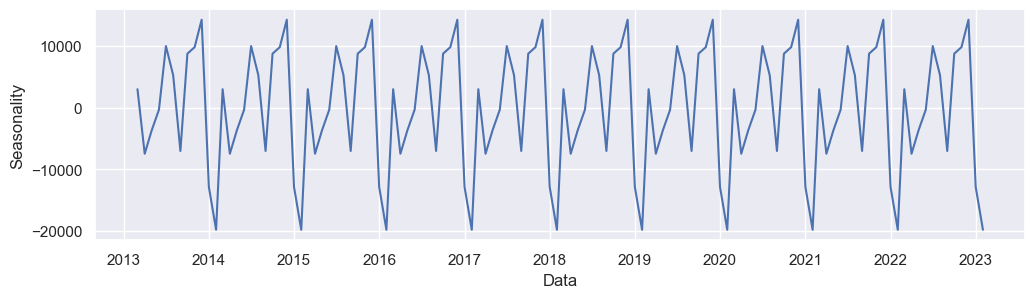

In [7]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_pib['Data'][len(df_pib)-120:], decomposed_ts.seasonal[len(df_pib)-120:])
plt.xlabel('Data')
plt.ylabel('Seasonality')
plt.show();

## Creating and  Adjusting Exponential Smoothing Models

Based on the charts, it is evident that there is an annual seasonal pattern along with a positive trend (A slight downward pattern can be observed during 2020). Therefore, the Holt-Winters model is likely to provide the most accurate predictions.

In [8]:
# Splitting the dataset on test and train (considering a point where the dataframe will be divided)
split_index = df_pib.loc[df_pib['Data']==dt.datetime(2021,1,1)].index[0]
df_train = df_pib['pib'].loc[:split_index]
df_test = df_pib['pib'].loc[split_index+1:]

In [9]:
# SES Model
model_ses = sm.tsa.SimpleExpSmoothing(df_train, initialization_method='estimated')
model_ses = model_ses.fit()
model_ses.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,SimpleExpSmoothing,SSE,46031489815.797
Optimized:,True,AIC,3946.064
Trend:,None,BIC,3952.710
Seasonal:,None,AICC,3946.264
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7183891,alpha,True
initial_level,1.4524e+05,l.0,True


In [10]:
# Holt Linear Model
model_holt = Holt(df_train, damped_trend=False, initialization_method='estimated')
model_holt = model_holt.fit()
model_holt.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,Holt,SSE,43000243250.092
Optimized:,True,AIC,3936.100
Trend:,Additive,BIC,3949.392
Seasonal:,None,AICC,3936.524
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5471429,alpha,True
smoothing_trend,0.0001,beta,True


In [11]:
# Model Holt Winter (Additive)
model_hw_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add = model_hw_add.fit()
model_hw_add.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,ExponentialSmoothing,SSE,20831415716.440
Optimized:,True,AIC,3811.527
Trend:,Additive,BIC,3864.695
Seasonal:,Additive,AICC,3815.205
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7121429,alpha,True
smoothing_trend,0.0001,beta,True


In [12]:
# Model Holt Winter (Multiplicative)
model_hw_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul = model_hw_mul.fit()
model_hw_mul.summary()

Dep. Variable:,pib,No. Observations:,205
Model:,ExponentialSmoothing,SSE,20064924466.934
Optimized:,True,AIC,3803.842
Trend:,Multiplicative,BIC,3857.010
Seasonal:,Multiplicative,AICC,3807.519
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7475000,alpha,True
smoothing_trend,0.0299000,beta,True


## Creating and Adjusting the best ARIMA Model

The ARIMA and SARIMA models are suitable for stationary data; however, the used function (auto_arima) will automatically handle the data to ensure stationarity. When examining the time series plots of the GDP, it becomes evident that there is no presence of seasonality in the data. Nevertheless, it is necessary to conduct the Dickey-Fuller test to formally confirm stationarity.

In [13]:
# Dickey Fuller Test
adf_result = adfuller(df_pib['pib'], maxlag=1)
adf_result

(0.15784301799307843,
 0.969795511392327,
 1,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 5097.93340221011)

A p-value of 0.97 in the Dickey-Fuller test indicates that there is no statistical evidence to reject the null hypothesis that the time series is non-stationary. In other words, such a high p-value suggests that the time series is non-stationary and exhibits some form of significant trend or pattern.

The main technique for addressing the stationarity of data in time series is differencing. Differencing involves calculating the differences between consecutive observations of the time series. However, in the current case, it will not be necessary to apply this technique.

The auto_arima function will find the best ARIMA model that fits the data in terms of dependence on past observations for current forecasting (Autoregressive = AR), the need for differencing (I), dependence on past forecast errors for current forecasting (Moving Average = MA), and it will also consider these factors for the seasonal component, as observed earlier.

In [14]:
# Creating the ARIMA model
arima_model = auto_arima(df_pib['pib'].loc[df_train.index], trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4511.396, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4462.459, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4470.730, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4514.832, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4506.605, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4459.213, Time=0.22 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4460.978, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4463.174, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=4462.436, Time=0.18 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=4456.725, Time=0.26 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=4459.659, Time=0.11 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=4457.561, Time=0.39 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=4461.345, Time=0.20 sec
 ARIMA(3,1,0)(2,0,0)[12]

In [15]:
# Fitting
arima_model.fit(df_pib['pib'].loc[df_train.index])

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [16]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  205
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood               -2219.214
Date:                             Tue, 06 Jun 2023   AIC                           4452.429
Time:                                     15:58:27   BIC                           4475.655
Sample:                                          0   HQIC                          4461.824
                                             - 205                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4487.6778   2385.835      1.881      0.060    -188.474    9163.829
ar.L1         -1.0956      0.098    -11.175      0.000      -1.288      -0.903
ar.L2         -0.1860      0.067     -2.756      0.006      -0.318      -0.054
ma.L1          0.9544      0.059     16.124      0.000       0.838       1.070
ar.S.L12       0.2863      0.027     10.478      0.000       0.233       0.340
ar.S.L24       0.1884      0.042      4.513      0.000       0.107       0.270
sigma2      2.037e+08      0.078   2.61e+09      0.000    2.04e+08    2.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               244.79
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+25. Standard errors may be unstable.
"""

## Checking Predictions and the Model's MAPE

In [17]:
# Creating a function to calculate the MAPE
def mape(serie):
    if type(serie) == pd.Series:
        return round((np.mean(abs((df_test.values-serie.values)/df_test.values))*100),2)
    elif type(serie) == np.ndarray:
         return round((np.mean(abs((df_test-serie)/df_test))*100),2)

# Creating a dataframe to list the values
df_mape = pd.DataFrame(index=['full data'], columns=['SES', 'Holt', 'HW (add)', 'HW (mul)', 'ARIMA'])

In [18]:
# Getting SES predictions
ses_predictions = model_ses.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions = model_holt.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions = model_hw_add.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions = model_hw_mul.forecast(steps=len(df_test))
# Getting ARIMA model predictions
arima_predictions = arima_model.predict(n_periods=len(df_test))

In [19]:
# Adding MAPE values
df_mape['SES'].loc['full data'] = mape(ses_predictions)
df_mape['Holt'].loc['full data'] = mape(holt_predictions)
df_mape['HW (add)'].loc['full data'] = mape(hw_add_predictions)
df_mape['HW (mul)'].loc['full data'] = mape(hw_mul_predictions)
df_mape['ARIMA'].loc['full data'] = mape(arima_predictions)

In [20]:
# Checking MAPE values
df_mape

,SES,Holt,HW (add),HW (mul),ARIMA
full data,15.47,10.19,12.28,8.58,10.61


As we can observe, the Holt-Winters Multiplicative model yielded the best predictions with a MAPE of 8.6%. The ARIMA and Holt methods had similar MAPE values, both around 10%.

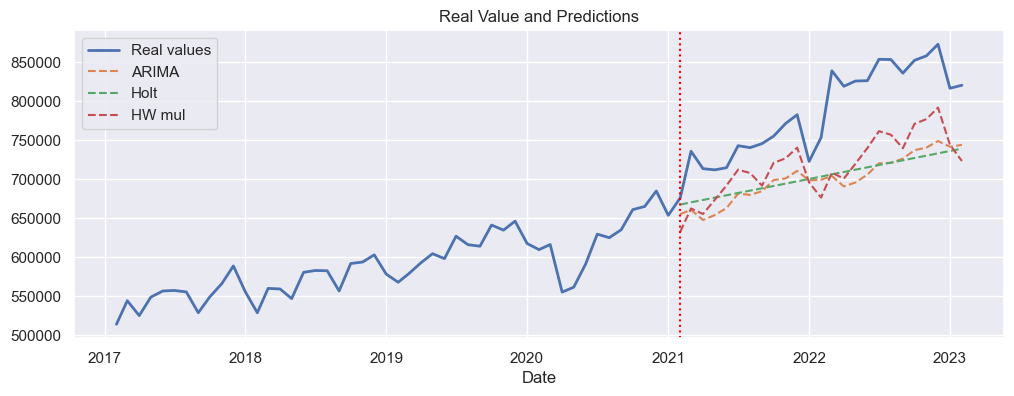

In [21]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], df_pib['pib'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], lw=2)
plt.plot(df_pib['Data'].loc[df_test.index], arima_predictions, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], holt_predictions, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], hw_mul_predictions, linestyle='dashed')
plt.legend(['Real values', 'ARIMA','Holt', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2021, 2, 1), color='red', linestyle='dotted')
plt.show();

As observed, the MAPE of the models showed a significant reduction with the new dataset.

The Holt Winter Multiplicative model once again achieved the best predictions, with the MAPE decreasing from 8.6% to 5%. The ARIMA model, which had previously performed well, had its MAPE reduced by almost half. However, the Holt model had a lower predictive performance after excluding the data.

This indicates that the removal of data from January to August 2020 positively influenced the prediction of the models. The best model predicts the data from January 2021 onwards with an average percentage error of 5%, which is superior to the 8% obtained without removing the data.

## Reapeating the Processes

In [22]:
# max index
to_delete_dates = df_pib.loc[(df_pib['Data']>=dt.datetime(2020,1,1))&(df_pib['Data']<=dt.datetime(2020,8,1))].index

In [23]:
# Reduced train data
df_train_reduced = df_train.drop(to_delete_dates)

In [24]:
# SES Model
model_ses2 = sm.tsa.SimpleExpSmoothing(df_train_reduced, initialization_method='estimated')
model_ses2 = model_ses2.fit()
model_ses2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,SimpleExpSmoothing,SSE,37832582467.364
Optimized:,True,AIC,3761.427
Trend:,None,BIC,3767.993
Seasonal:,None,AICC,3761.635
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6266279,alpha,True
initial_level,1.4374e+05,l.0,True


In [25]:
# Holt Linear Model
model_holt2 = Holt(df_train_reduced, damped_trend=False, initialization_method='estimated')
model_holt2 = model_holt2.fit()
model_holt2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,Holt,SSE,32393813802.527
Optimized:,True,AIC,3734.852
Trend:,Additive,BIC,3747.985
Seasonal:,None,AICC,3735.294
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3350000,alpha,True
smoothing_trend,0.0001,beta,True


In [26]:
# Model Holt Winter (Additive)
model_hw_add2 = ExponentialSmoothing(df_train_reduced, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add2 = model_hw_add2.fit()
model_hw_add2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,ExponentialSmoothing,SSE,14706104474.288
Optimized:,True,AIC,3603.280
Trend:,Additive,BIC,3655.811
Seasonal:,Additive,AICC,3607.123
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3585714,alpha,True
smoothing_trend,0.0632773,beta,True


In [27]:
# Model Holt Winter (Multiplicative)
model_hw_mul2 = ExponentialSmoothing(df_train_reduced, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul2 = model_hw_mul2.fit()
model_hw_mul2.summary()

Dep. Variable:,pib,No. Observations:,197
Model:,ExponentialSmoothing,SSE,16834547031.900
Optimized:,True,AIC,3629.909
Trend:,Multiplicative,BIC,3682.440
Seasonal:,Multiplicative,AICC,3633.751
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:58:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3232143,alpha,True
smoothing_trend,0.0606027,beta,True


In [28]:
# Creating the ARIMA model
arima_model2 = auto_arima(df_train_reduced, trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4257.668, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4310.539, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4259.296, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4264.429, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4314.918, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4263.093, Time=0.35 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4256.836, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=4300.239, Time=0.24 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4255.458, Time=0.78 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=4254.145, Time=1.22 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=4255.986, Time=0.84 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=4252.605, Time=0.97 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=4259.762, Time=0.32 sec
 ARIMA(1,1,2)(2,0,0)[12]

In [29]:
# Fitting
arima_model2.fit(df_train_reduced)

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

In [30]:
# Model Outputs
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  197
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -2118.302
Date:                              Tue, 06 Jun 2023   AIC                           4252.605
Time:                                      15:58:46   BIC                           4278.830
Sample:                                           0   HQIC                          4263.222
                                              - 197                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6908.7608   2752.060      2.510      0.012    1514.823    1.23e+04
ar.L1         -0.8786      0.148     -5.928      0.000      -1.169      -0.588
ma.L1          0.6005      0.151      3.984      0.000       0.305       0.896
ma.L2         -0.3017      0.045     -6.636      0.000      -0.391      -0.213
ar.S.L12      -0.2591      0.391     -0.662      0.508      -1.026       0.508
ar.S.L24       0.3016      0.148      2.037      0.042       0.011       0.592
ma.S.L12       0.5994      0.406      1.477      0.140      -0.196       1.395
sigma2      1.601e+08      0.074   2.16e+09      0.000     1.6e+08     1.6e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               113.96
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.76
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.97e+25. Standard errors may be unstable.
"""

In [31]:
# Getting SES predictions
ses_predictions2 = model_ses2.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions2 = model_holt2.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions2 = model_hw_add2.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions2 = model_hw_mul2.forecast(steps=len(df_test))
# Getting Arima predictions
arima_predictions2 = arima_model2.predict(n_periods=len(df_test))

In [32]:
# Creating a dataframe to list the values
df_mape = df_mape.append(pd.Series([None, None,None,None,None], index=df_mape.columns, name='reduced data'))

# Adding MAPE values
df_mape['SES'].loc['reduced data'] = mape(ses_predictions2)
df_mape['Holt'].loc['reduced data'] = mape(holt_predictions2)
df_mape['HW (add)'].loc['reduced data'] = mape(hw_add_predictions2)
df_mape['HW (mul)'].loc['reduced data'] = mape(hw_mul_predictions2)
df_mape['ARIMA'].loc['reduced data'] = mape(arima_predictions2)

In [33]:
# checking MAPE values
df_mape

,SES,Holt,HW (add),HW (mul),ARIMA
full data,15.47,10.19,12.28,8.58,10.61
reduced data,15.3,10.11,6.78,4.92,8.15


## Conclusions

Based on the MAPE values, it can be observed that, in general, the models performed better when excluding the months between January and August 2020 (months in which the GDP exhibited a significant deviation, most likely due to the COVID-19 pandemic).

The Simple Exponential Smoothing and Holt models showed a negligible improvement in performance, while the MAPE values for the Additive and Multiplicative Holt-Winters models showed a significant decrease (almost halved). The adjusted ARIMA model also showed an improvement after excluding the data.

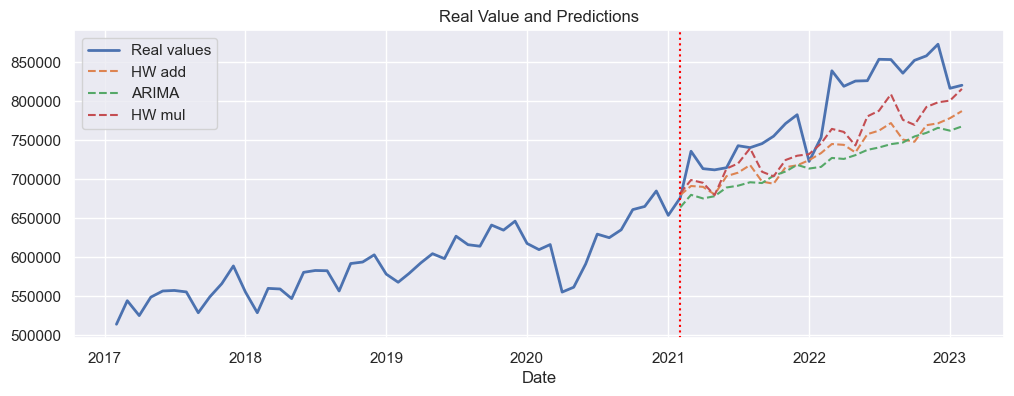

In [34]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_pib['Data'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], df_pib['pib'].loc[df_pib['Data']>dt.datetime(2017, 1, 1)], lw=2)
plt.plot(df_pib['Data'].loc[df_test.index], hw_add_predictions2, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], arima_predictions2, linestyle='dashed')
plt.plot(df_pib['Data'].loc[df_test.index], hw_mul_predictions2, linestyle='dashed')
plt.legend(['Real values', 'HW add','ARIMA', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2021, 2, 1), color='red', linestyle='dotted')
plt.show();


Observing the graph and comparing it to the previous one, it is possible to notice that an atypical period, such as the initial months of the COVID-19 pandemic, can have a significant impact on time series models, and excluding it can improve the predictive performance of the model.

However, this approach does not work in all cases, so it is essential to test different configurations when building models in order to find the one that best fits the data and provides the most accurate predictions.

The final conclusion is that the time series models were able to make good predictions for the last two years of the Brazilian GDP, especially when excluding the first months of 2020 from the dataset.